In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from torchvision import datasets, transforms, models

data_dir = './stanford-car-classification/car_ims'

In [4]:
from scipy import io
mat_file = io.loadmat('./stanford-car-classification/devkit/cars_meta.mat')

In [5]:
class_names = []
for i in range(len(mat_file.get('class_names')[0])):
    class_names.append(mat_file.get('class_names')[0][i][0])
print(class_names)
data_frame = len(mat_file.get('class_names')[0])
print(data_frame)

['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW Z4 Convertible 2012

In [6]:
for c in class_names:
    os.makedirs('./stanford-car-classification/train_cars/' + c, exist_ok = True)
    os.makedirs('./stanford-car-classification/test_cars/' + c, exist_ok = True)
    os.makedirs('./stanford-car-classification/val_cars/' + c, exist_ok = True)

In [7]:
mat_train_file = io.loadmat('./stanford-car-classification/data/cars_annos.mat')
box = []
for i in range(16185):
    temp = []
    for j in range(1,5,1):
        temp.append(mat_train_file.get('annotations')[0][i][j][0][0])
    box.append(temp)
box

[[112, 7, 853, 717],
 [48, 24, 441, 202],
 [7, 4, 277, 180],
 [33, 50, 197, 150],
 [5, 8, 83, 58],
 [10, 6, 250, 110],
 [56, 1, 394, 176],
 [1, 13, 113, 83],
 [15, 111, 271, 272],
 [14, 18, 148, 107],
 [5, 8, 91, 59],
 [29, 18, 157, 86],
 [1, 1, 300, 179],
 [9, 1, 152, 103],
 [4, 15, 94, 63],
 [12, 16, 117, 71],
 [1, 5, 160, 89],
 [46, 84, 661, 428],
 [86, 81, 371, 252],
 [26, 32, 677, 418],
 [50, 127, 587, 396],
 [6, 9, 124, 89],
 [52, 25, 751, 507],
 [3, 23, 132, 98],
 [60, 76, 593, 393],
 [21, 18, 492, 316],
 [11, 31, 490, 266],
 [8, 3, 135, 86],
 [30, 65, 331, 199],
 [5, 14, 93, 58],
 [125, 645, 1845, 1421],
 [20, 48, 385, 283],
 [51, 73, 570, 426],
 [79, 469, 1537, 1198],
 [18, 18, 328, 190],
 [13, 235, 2021, 1253],
 [6, 20, 123, 88],
 [26, 25, 283, 157],
 [61, 98, 458, 376],
 [111, 213, 907, 683],
 [178, 214, 901, 658],
 [9, 14, 490, 368],
 [28, 48, 663, 302],
 [4, 9, 96, 88],
 [6, 7, 94, 68],
 [14, 16, 268, 169],
 [10, 18, 89, 61],
 [111, 54, 365, 190],
 [9, 33, 479, 276],
 [9, 

In [8]:
image_files = ['./stanford-car-classification/' + mat_train_file.get('annotations')[0][i][0][0] for i in range(16185)]
               
print(image_files)

['./stanford-car-classification/car_ims/000001.jpg', './stanford-car-classification/car_ims/000002.jpg', './stanford-car-classification/car_ims/000003.jpg', './stanford-car-classification/car_ims/000004.jpg', './stanford-car-classification/car_ims/000005.jpg', './stanford-car-classification/car_ims/000006.jpg', './stanford-car-classification/car_ims/000007.jpg', './stanford-car-classification/car_ims/000008.jpg', './stanford-car-classification/car_ims/000009.jpg', './stanford-car-classification/car_ims/000010.jpg', './stanford-car-classification/car_ims/000011.jpg', './stanford-car-classification/car_ims/000012.jpg', './stanford-car-classification/car_ims/000013.jpg', './stanford-car-classification/car_ims/000014.jpg', './stanford-car-classification/car_ims/000015.jpg', './stanford-car-classification/car_ims/000016.jpg', './stanford-car-classification/car_ims/000017.jpg', './stanford-car-classification/car_ims/000018.jpg', './stanford-car-classification/car_ims/000019.jpg', './stanford

In [9]:
def process_image(i,image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # Resize the images where the shortest side is 256 pixels, keeping the aspect ratio
    pil_image = Image.open(image)
    pil_image = pil_image.crop((round(box[i][0]), round(box[i][1]), round(box[i][2]), round(box[i][3])))
    pil_image = pil_image.resize((224, 224))
    
    return pil_image

In [10]:
train_dir='./stanford-car-classification/train_cars/'
val_dir='./stanford-car-classification/val_cars/'
test_dir='./stanford-car-classification/test_cars/'

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))
    
means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4214, 0.4010, 0.4032])
Calculated stds: tensor([0.2683, 0.2643, 0.2664])


In [11]:
pretrained_size=224
calculated_means = [0.4214, 0.4010, 0.4032]
calculated_stds = [0.2683, 0.2643, 0.2664]

train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=calculated_means,
                                                std=calculated_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=calculated_means,
                                                std=calculated_stds)
                       ])

In [158]:
# Prepare training, validation, and test data lists
valid_frac, test_frac = 0.09, 0.1
trainX = []
valX = []
testX = []

for k in range(196):
    for i in range(82):
        j = image_files[82*k+i]
        r = j.split('/')[-1]
        rann = np.random.random()
        if rann < test_frac:
            testX.append(image_files[82*k+i])
            process_image(82*k+i,j).save(f'./stanford-car-classification/test_cars/{class_names[k]}/{r}')
        elif rann < test_frac + valid_frac:
            valX.append(image_files[82*k+i])
            process_image(82*k+i,j).save(f'./stanford-car-classification/val_cars/{class_names[k]}/{r}')
        else:
            trainX.append(image_files[82*k+i])  
            process_image(82*k+i,j).save(f'./stanford-car-classification/train_cars/{class_names[k]}/{r}')
    
print(len(trainX), len(valX), len(testX))
print(trainX)

12959 1434 1679
['./stanford-car-classification/car_ims/000001.jpg', './stanford-car-classification/car_ims/000002.jpg', './stanford-car-classification/car_ims/000003.jpg', './stanford-car-classification/car_ims/000004.jpg', './stanford-car-classification/car_ims/000005.jpg', './stanford-car-classification/car_ims/000006.jpg', './stanford-car-classification/car_ims/000007.jpg', './stanford-car-classification/car_ims/000008.jpg', './stanford-car-classification/car_ims/000009.jpg', './stanford-car-classification/car_ims/000010.jpg', './stanford-car-classification/car_ims/000011.jpg', './stanford-car-classification/car_ims/000012.jpg', './stanford-car-classification/car_ims/000013.jpg', './stanford-car-classification/car_ims/000014.jpg', './stanford-car-classification/car_ims/000015.jpg', './stanford-car-classification/car_ims/000016.jpg', './stanford-car-classification/car_ims/000017.jpg', './stanford-car-classification/car_ims/000019.jpg', './stanford-car-classification/car_ims/000020.j

In [12]:

batch_size = 32

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



# TODO: Load the datasets with imageFolder
image_datasets = {}
image_datasets["train"] = datasets.ImageFolder(root = train_dir, transform=train_transforms)
image_datasets["valid"] = datasets.ImageFolder(root = val_dir, transform=test_transforms)
image_datasets["test"] = datasets.ImageFolder(root = test_dir, transform=test_transforms)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

# TODO: Using the image datasets and the transforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(image_datasets["train"], batch_size=batch_size, shuffle = True,
                                          num_workers = 2)
valid_loader = torch.utils.data.DataLoader(image_datasets["valid"], batch_size=batch_size, shuffle = False,
                                          num_workers = 2)
test_loader = torch.utils.data.DataLoader(image_datasets["test"], batch_size=batch_size, shuffle = False,
                                         num_workers = 2)

print(dataset_sizes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'train': 12959, 'valid': 1434, 'test': 1679}
cuda:0


In [13]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [14]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = class_names[labels[i]]
        ax.set_title(label)
        ax.axis('off')

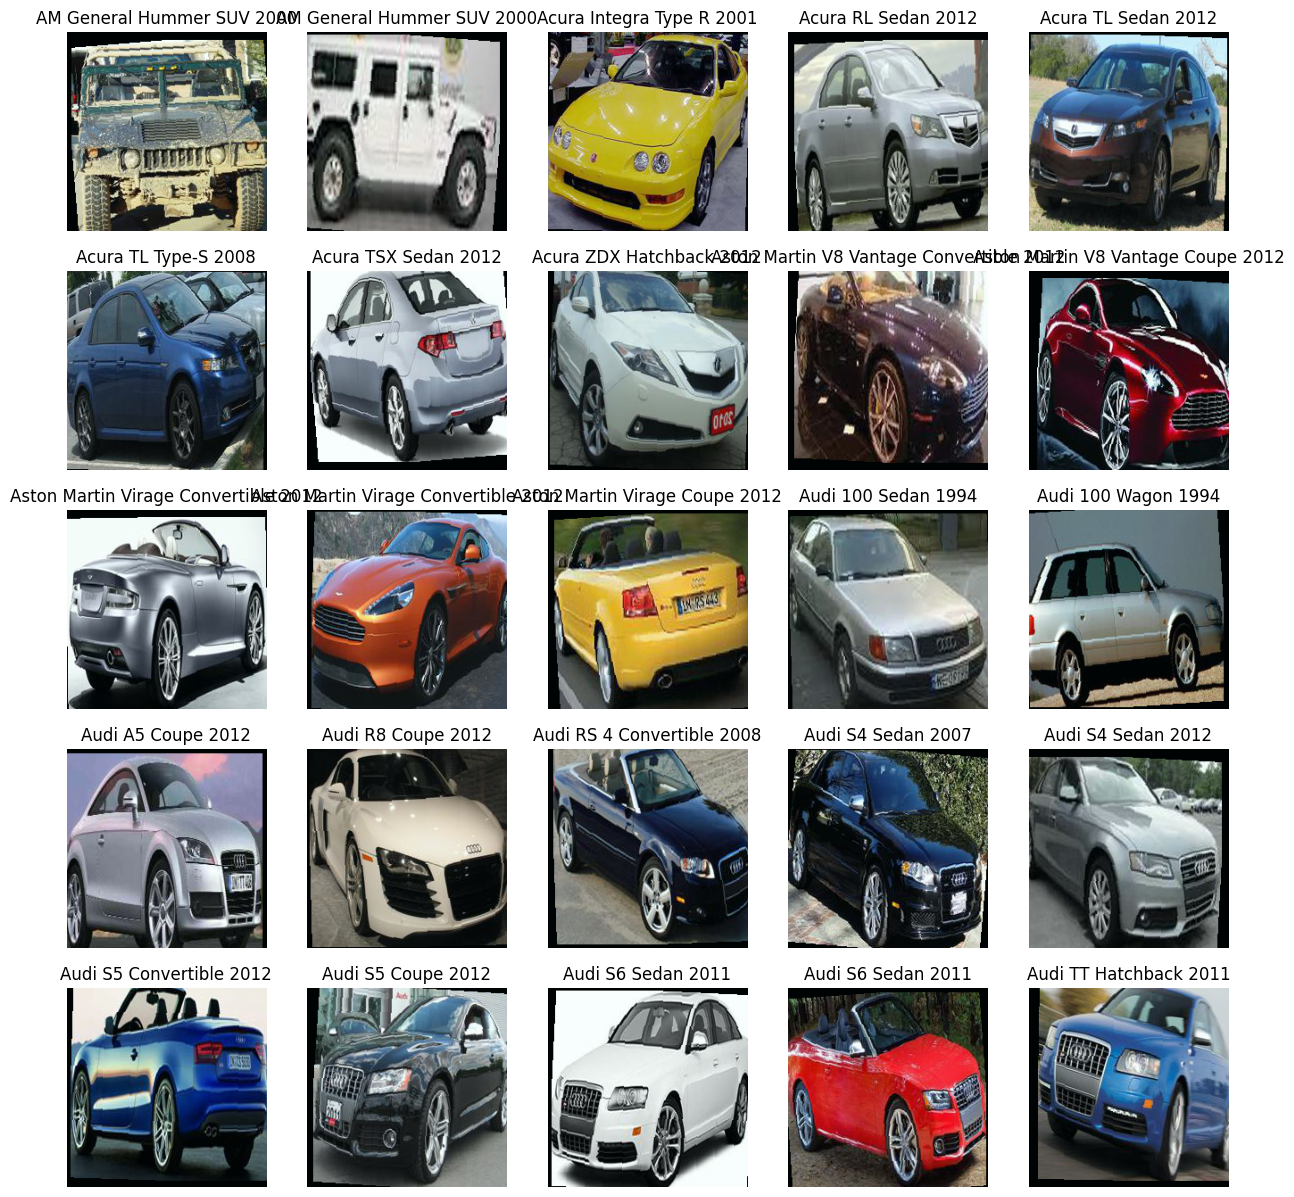

In [15]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [image_datasets["train"][i] for i in range(0,N_IMAGES*59,59)]])

class_names = image_datasets["test"].classes

plot_images(images, labels, class_names)

In [16]:
def format_label(label):
    label = label.replace(' ','')
    label = label[:-4]
    return label

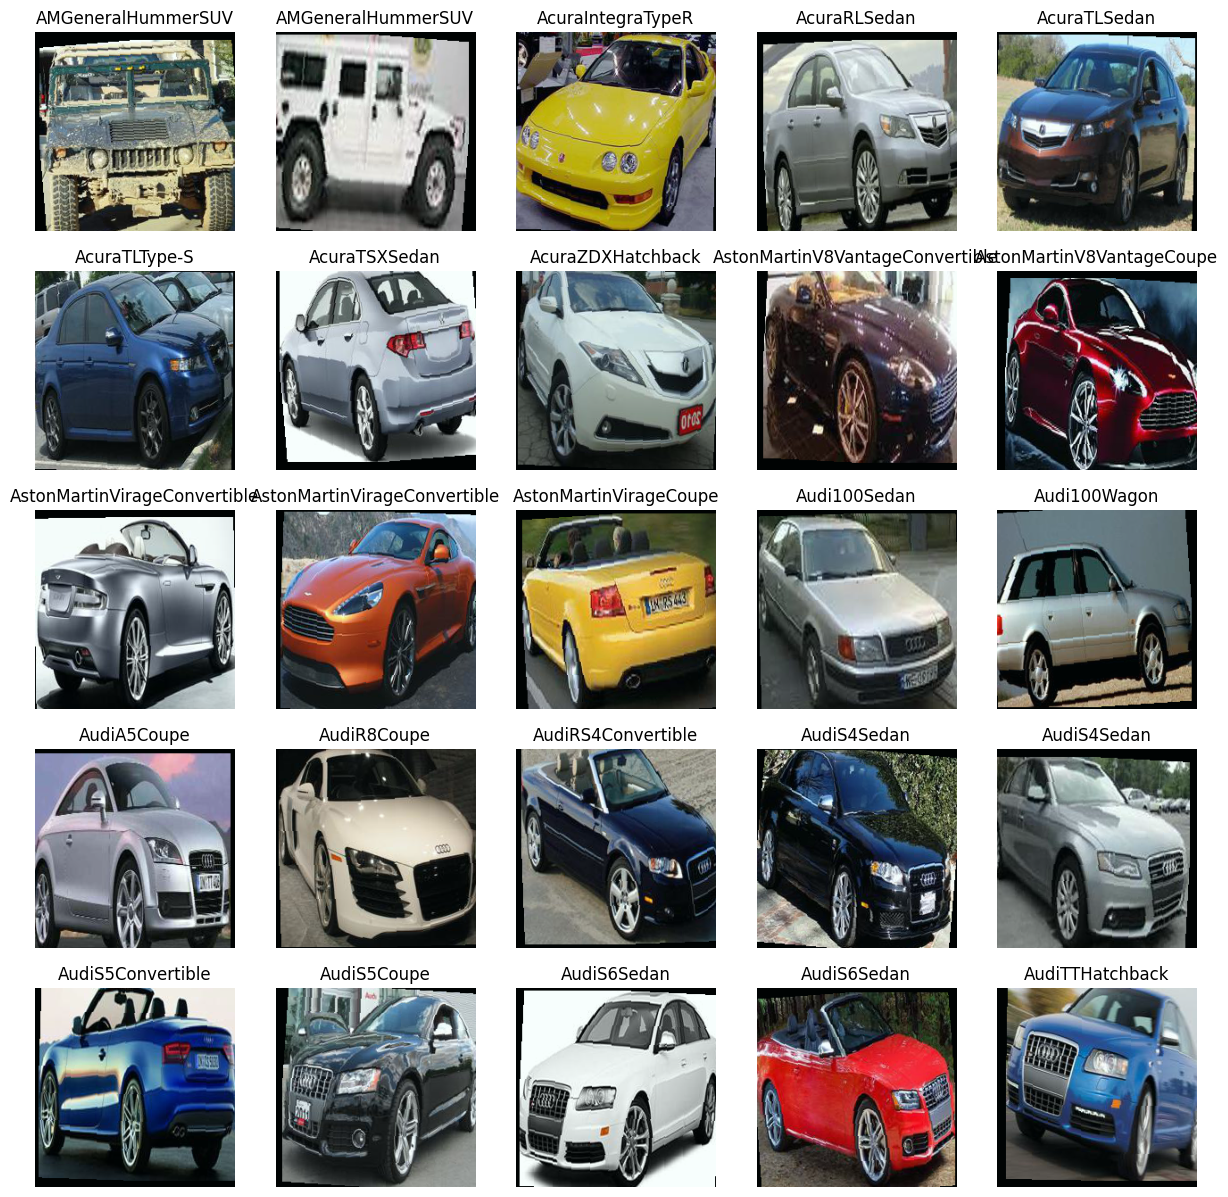

In [17]:
image_datasets["test"].classes = [format_label(c) for c in image_datasets["test"].classes]

class_names = image_datasets["test"].classes

plot_images(images, labels, class_names)

In [71]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7, 3, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, 2, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(3, 3), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [18]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [19]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(out_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
    
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [20]:
from collections import namedtuple

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [21]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [22]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [23]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [70]:
class CIFARResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, layers, channels = config
        self.in_channels = channels[0]
            
        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [71]:
class Identity(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        
    def forward(self, x):
        return self.f(x)
        

class CIFARBasicBlock(nn.Module):
        
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            identity_fn = lambda x : F.pad(x[:, :, ::2, ::2], 
                                           [0, 0, 0, 0, in_channels // 2, in_channels // 2])
            downsample = Identity(identity_fn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                                
        x += i
        x = self.relu(x)
        
        return x

In [72]:
cifar_resnet20_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [3, 3, 3],
                                     channels = [16, 32, 64])

cifar_resnet32_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [5, 5, 5],
                                     channels = [16, 32, 64])

cifar_resnet44_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [7, 7, 7],
                                     channels = [16, 32, 64])

cifar_resnet56_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [9, 9, 9],
                                     channels = [16, 32, 64])

cifar_resnet110_config = ResNetConfig(block = CIFARBasicBlock,
                                      n_blocks = [18, 18, 18],
                                      channels = [16, 32, 64])

cifar_resnet1202_config = ResNetConfig(block = CIFARBasicBlock,
                                       n_blocks = [20, 20, 20],
                                       channels = [16, 32, 64])

In [24]:
pretrained_model = models.resnet50(pretrained = True)

C:\Users\young\anaconda3_1\envs\youngs\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\young\anaconda3_1\envs\youngs\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(image_datasets["test"].classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [27]:
pretrained_model.fc = fc

In [28]:
model = ResNet(resnet50_config, OUTPUT_DIM)

In [29]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,909,636 trainable parameters


In [31]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [32]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [33]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [186]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [34]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

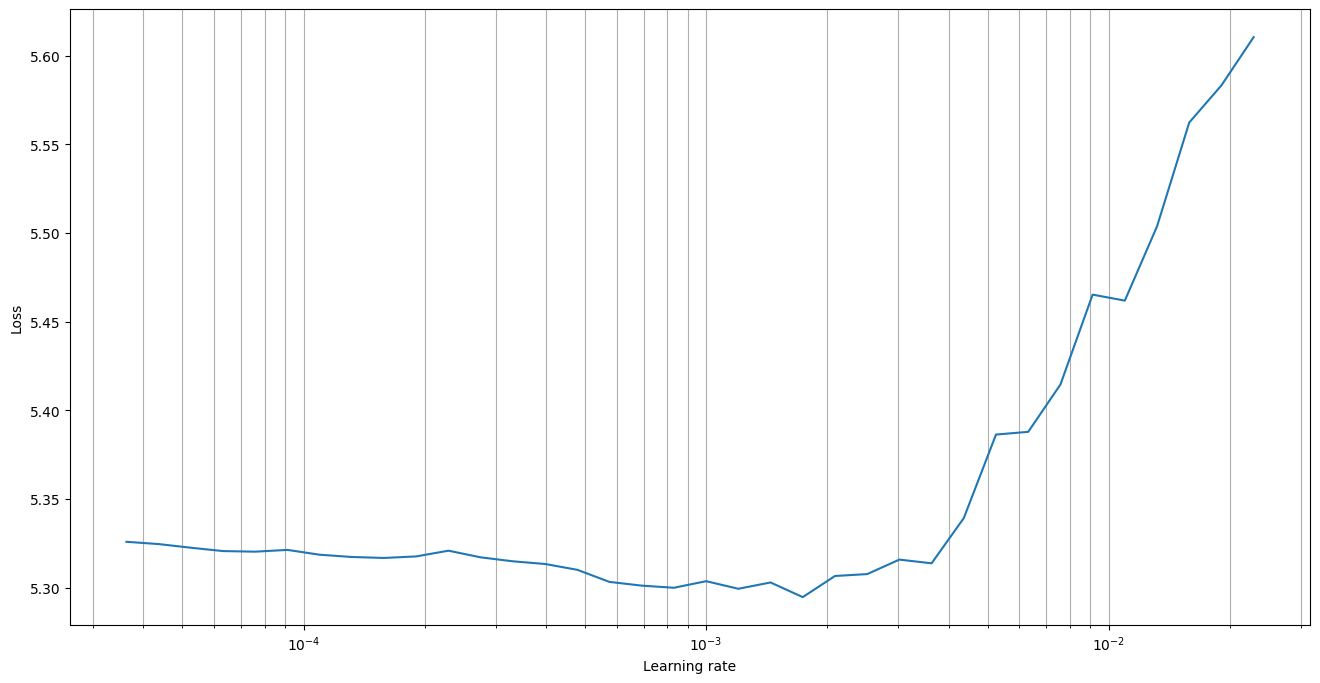

In [35]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [36]:
FOUND_LR = 8e-4

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [37]:
import torch.optim as optim

EPOCHS = 10
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer, 
                                    max_lr = MAX_LRS, 
                                    total_steps = TOTAL_STEPS)

In [38]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
#         print('y_pred.shape',y_pred.shape)
#         print('y.shape',y.shape)
        _, top_pred = y_pred.topk(k, 1)
#         print('1st', top_pred)
        top_pred = top_pred.t()
#         print('2nd', top_pred)
#         print('y',y.view(1,-1))
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
#         print('correct', correct)
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
#         print('correct_1', correct_1)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
#         print('correct_k', correct_k)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [39]:
from tqdm import tqdm

def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [40]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [41]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
best_valid_loss = float('inf')

for epoch in tqdm(range(EPOCHS)):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_loader, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

 10%|████████▏                                                                         | 1/10 [02:31<22:40, 151.21s/it]

Epoch: 01 | Epoch Time: 2m 31s
	Train Loss: 4.710 | Train Acc @1:   8.27% | Train Acc @5:  22.22%
	Valid Loss: 3.376 | Valid Acc @1:  23.99% | Valid Acc @5:  55.29%


 20%|████████████████▍                                                                 | 2/10 [05:02<20:11, 151.44s/it]

Epoch: 02 | Epoch Time: 2m 31s
	Train Loss: 2.427 | Train Acc @1:  38.52% | Train Acc @5:  74.58%
	Valid Loss: 2.056 | Valid Acc @1:  43.91% | Valid Acc @5:  82.02%


 30%|████████████████████████▌                                                         | 3/10 [07:35<17:42, 151.81s/it]

Epoch: 03 | Epoch Time: 2m 32s
	Train Loss: 1.738 | Train Acc @1:  50.14% | Train Acc @5:  87.19%
	Valid Loss: 2.000 | Valid Acc @1:  46.14% | Valid Acc @5:  82.40%


 40%|████████████████████████████████▊                                                 | 4/10 [10:08<15:15, 152.64s/it]

Epoch: 04 | Epoch Time: 2m 33s
	Train Loss: 1.377 | Train Acc @1:  57.30% | Train Acc @5:  93.29%
	Valid Loss: 1.433 | Valid Acc @1:  56.71% | Valid Acc @5:  92.73%


 50%|█████████████████████████████████████████                                         | 5/10 [12:43<12:46, 153.32s/it]

Epoch: 05 | Epoch Time: 2m 34s
	Train Loss: 1.066 | Train Acc @1:  64.35% | Train Acc @5:  97.01%
	Valid Loss: 1.295 | Valid Acc @1:  59.02% | Valid Acc @5:  94.85%


 60%|█████████████████████████████████████████████████▏                                | 6/10 [15:16<10:13, 153.28s/it]

Epoch: 06 | Epoch Time: 2m 33s
	Train Loss: 0.832 | Train Acc @1:  70.19% | Train Acc @5:  98.64%
	Valid Loss: 1.012 | Valid Acc @1:  65.41% | Valid Acc @5:  96.37%


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [17:49<07:38, 153.00s/it]

Epoch: 07 | Epoch Time: 2m 32s
	Train Loss: 0.619 | Train Acc @1:  75.83% | Train Acc @5:  99.58%
	Valid Loss: 0.992 | Valid Acc @1:  67.13% | Valid Acc @5:  97.54%


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [20:20<05:05, 152.61s/it]

Epoch: 08 | Epoch Time: 2m 31s
	Train Loss: 0.442 | Train Acc @1:  82.16% | Train Acc @5:  99.90%
	Valid Loss: 0.960 | Valid Acc @1:  66.68% | Valid Acc @5:  97.87%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [22:52<02:32, 152.28s/it]

Epoch: 09 | Epoch Time: 2m 31s
	Train Loss: 0.304 | Train Acc @1:  88.56% | Train Acc @5:  99.98%
	Valid Loss: 0.909 | Valid Acc @1:  68.81% | Valid Acc @5:  98.23%


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [25:23<00:00, 152.39s/it]

Epoch: 10 | Epoch Time: 2m 31s
	Train Loss: 0.242 | Train Acc @1:  91.79% | Train Acc @5:  99.99%
	Valid Loss: 0.913 | Valid Acc @1:  69.23% | Valid Acc @5:  98.30%


In [43]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 0.952 | Test Acc @1:  67.06% | Test Acc @5:  98.00%
